In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

# Towards Bayesian BRDF linear model understanding
### J Gómez-Dans (NCEO & UCL)


## Uncertainty

We haven't said anything about how uncertain data is. In this case, the solution will not change if we assume that all observations have the same uncertainty associated (e.g. $\sigma^2\sim 0.005$, say). But depending on things like SZA, VZA and other stuff, this will change. It's only that we don't know how. But let's see how this would work.

Assuming no correlation between uncertainty in observations, we have that 
$$
\hat{\rho}^{\lambda_i}(\Omega, Omega') = \sum_{i=1}^{N_{kern}}f_{i}(\lambda_i)K_{i}(\Omega, \Omega') + \mathcal{N}(0, \sigma_{obs}),
$$

which is an additive, zero mean, Gaussian noise model. We can calculate the minus log-likelihood derived from a set of observations that we stack in a vector $\vec{\rho}$, where we also stack the kernels into a matrix $\mathbf{K}$, and the uncertainties into a covariance matrix $\mathbf{C}_{obs}$ (in this case, diagonal), we have:

$$
\log\left[p(\rho|\vec{f}\right] \propto \frac{1}{2}\left[\vec{\rho^{\lambda_i}} - \vec{f}\cdot\mathbf{K}\right]^{\top}\mathbf{C}_{obs}^{-1}\left[\vec{\rho^{\lambda_i}} - \vec{f}\cdot\mathbf{K}\right]
$$

We can find the maximum likelihood estimate by finding the minimum minus log-likelihood estimate: we equate the derivative to 0 and we have your bog-standard linear least squares solution with uncertainty. The optical weights are given by

$$
\mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K}\cdot \vec{f}_{opt} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\cdot\vec{\rho}
$$

And the uncertainty by the radius of curvature around the optimal point, or the inverse Hessian
$$
\mathbf{C}_{f}^{-1} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K}
$$

Implicitly, the solution is assumed to be multivariate Gaussian with mean $\vec{\rho}$ and covariance matrix $\mathbf{C}$

You may want to check [this document](https://doi.org/10.6084/m9.figshare.957577.v4) for a more thorough introduction to the maths behind this.

Let's see how this works in practice by using the `fit_period_prior` function:




OK, so let's use this again, and now plot the kernel weight uncertainties as vertical streak. We are not using any prior information here, although `fit_period_prior` can deal with that. It's the same as before, but now showing the uncertainty I have calculated as detailed above:

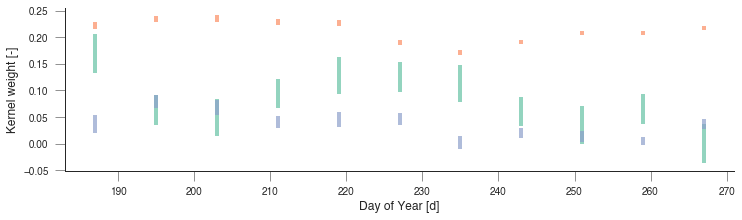

In [4]:
doys, qa, vza, sza, raa, rho, kern, n_obs = prepare_data()
colors = ["#FC8D62", "#66C2A5", "#8DA0CB"]
plt.figure(figsize=(12,3))
doy_start = 183
doy_end = doy_start + 8
while doy_end <= 273:
    f, fwd, obs, rmse, r2, the_unc, f_upper, f_lower, sigma_f = fit_period_prior(
        doys, qa, rho, doy_start, doy_end, 0.005, kern)
    t0 = 0.5*(doy_start + doy_end)
    for i in range(3):
        plt.vlines(t0, f[i]-1.96*sigma_f[i], f[i]+1.96*sigma_f[i], 
                   color=colors[i], lw=4, alpha=0.7)
    
    doy_end = doy_end + 8
    doy_start = doy_start + 8
_ = plt.xlabel("Day of Year [d]")
_ = plt.ylabel("Kernel weight [-]")

So we se that the isotropic kernel weights have very small uncertainty, whereas the geometric and particularly the volumetric have pretty large uncertainties. All this means is that there's a large range of e.g. volumetric kernel weights that allow one to fit the observations (within the given uncertainties) equally well. 

The above isn't very satisfying: things are moving all over the place. It is also clear that in areas of low dynamics, we could possibly extend the temporal window to get more observations, improve angular sampling (and perhaps downweight the contribution of the odd outlier), and get a more stable result. However, it's hard to figure out how to chooose the optimal window size. 


## Enter the Reverend...

Moving on forward, we might consider that we know stuff about this problem that we haven't used. I mean, all we've done is just fitted the data to some ropey observations. If we can bring in any extra (perhaps vague) information to our problem, we may get "better results". A neat way of doing this is to use Bayesian concepts.

![](http://jim-stone.staff.shef.ac.uk/BookBayes2012/HTML_BayesRulev5EbookHTMLFiles/ops/images/f0001-01.jpg)

It's Bayes that came up with the idea, and Laplace did a lot of the legwork in making it useful. It is now the remain of the latte-sipping, podcast-listening classes. I don't feel like giving you the lowdown in Bayesian stats, but [this book](http://jim-stone.staff.shef.ac.uk/BookBayes2012/HTML_BayesRulev5EbookHTMLFiles/ops/xhtml/ch01BayesJVSone.html) (where I nicked the photos above from) might be useful.

Anyhow, back to our thing. A clever way to improve on this might be to consider whether we can use the solution from the previous time step to constrain the solution from the current time step. Clever hey... In general, this is called "using a prior pdf", and is well known in the realm of Bayesian statistics (yeah, that weird bit that you never paid attention to because you were farting about with random forests or somesuch). Again, you may want to consult [this fine document](https://doi.org/10.6084/m9.figshare.957577.v4), and I will assume you understand most of it.

Basically, to the likelihood model we introduced above, Bayes' Rule states that the *a posteriori* probability of the model parameters ($\vec{f}$) given the observations ($\vec{\rho}$, $p(\vec{f}|\vec{\rho})$ is proportional to the product of the likelihood times the *a priori* pdf. 

$$
p(\vec{f}|\vec{\rho})\propto p(\vec{f}|\vec{\rho})\cdot p(\vec{rho})
$$

It turns out that the solution to this assuming a multivariate Gaussian pdf for the prior ($\mathcal{N}(\vec{f}_{prior}, \mathbf{C}_{prior}^{-1})$ is quite simple:
$$
\left[\mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\mathbf{K} + \mathbf{C}_{prior}^{-1}\right]\cdot \vec{f}_{opt} = \mathbf{K}^{\top}\mathbf{C}^{1}_{obs}\cdot\vec{\rho} + \mathbf{C}^{1}_{prior}\cdot\vec{f}_{prior}
$$

The clever bit here is not to use the uncertainty from the posterior from the previous time step directly, as that is only pertinent to the previous timestep, but to add a bit of extra uncertainty to account for changes. How much uncertainty you add is entirely up to you, but if you add too much you'll be back to the original problem, and if you add too little, you'll over costrain the solution!

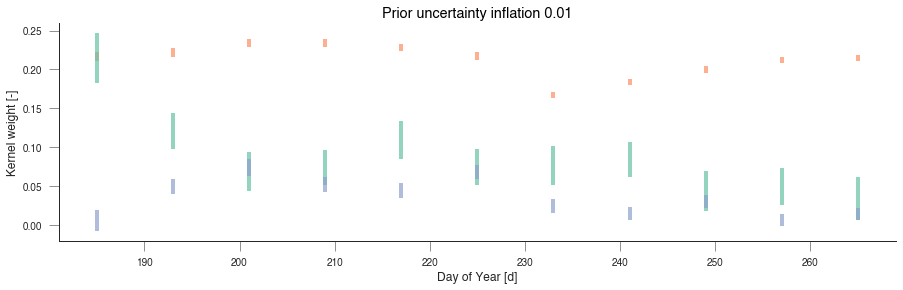

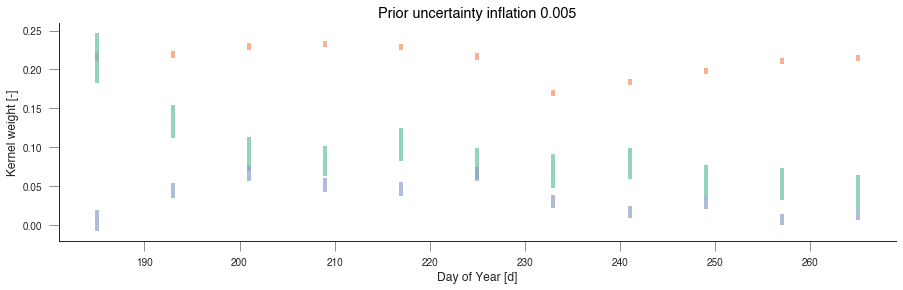

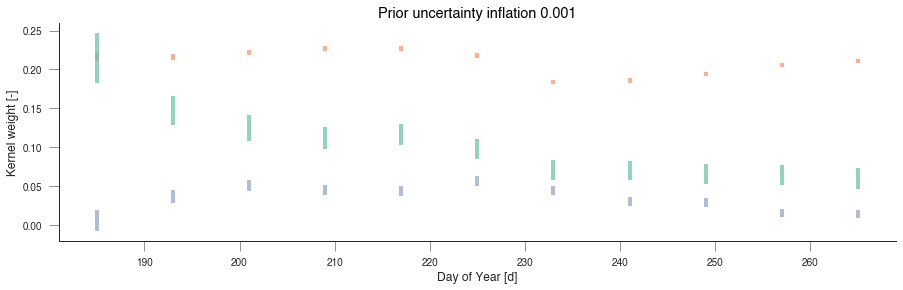

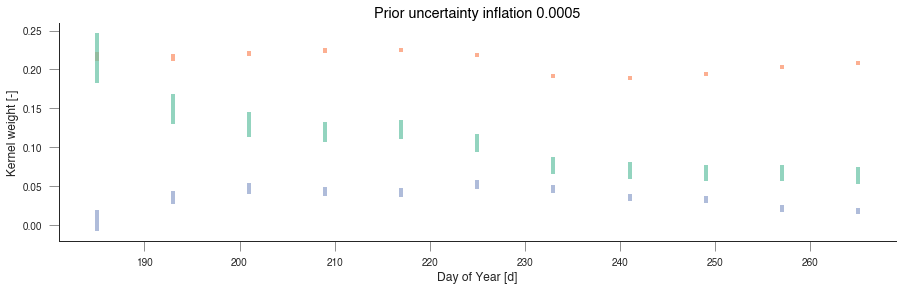

In [7]:

for add_unc in [0.01, 0.005, 0.001, 0.0005]:
    plt.figure(figsize=(15,4))
    colors = ["#FC8D62", "#66C2A5", "#8DA0CB"]
    prior_mean = np.array([0.2, 0., 0.])
    prior_std = np.array([0.5, 0.5, 0.5])
    doy_start = 181
    doy_end = doy_start + 8
    while doy_end <= 273:
        f, fwd, obs, rmse, r2, the_unc, f_upper, f_lower, sigma_f = fit_period_prior(
            doys, qa, rho, doy_start, doy_end, 0.005, kern, prior_mean=prior_mean,
            prior_std=prior_std)
        t0 = 0.5*(doy_start + doy_end)
        for i in range(3):
            plt.vlines(t0, f[i]-1.96*sigma_f[i], f[i]+1.96*sigma_f[i], 
                       color=colors[i], lw=4, alpha=0.7)
        prior_mean = f
        # Add some uncertainty!
        prior_std = sigma_f + np.ones(3)*add_unc
        doy_end = doy_end + 8
        doy_start = doy_start + 8
    _ = plt.xlabel("Day of Year [d]")
    _ = plt.ylabel("Kernel weight [-]")
    _ = plt.title(f"Prior uncertainty inflation {add_unc:g}")

We see that the kernel weight uncertainties shrink as we decrease the extra inflation passing information around. An effect of this is that we see how the change of reflectance due to the fire is stretched over and appears smoothed: as we trust the prior retrieval more and more, the system tries to balance this with the goodness of fit. So trusting the previous time step too much results in changes taking longer (e.g. requiring extra evidence)  to appear in the data.